<h1>Détection de tumeurs cérébrales avec CNN : Transfer Learning</h1>

<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dans ce projet, nous étudions la tâche de détection des cancers du cerveau à partir de scanners IRM en utilisant des réseaux neuronaux convolutionnels (CNN) et un modèles pré-entraîné (VGG 16). Les tumeurs cérébrales sont une préoccupation majeure pour la santé dans le monde entier, et un diagnostic précoce est essentiel pour le traitement et les résultats des patients. Avec les progrès réalisés dans les technologies d'apprentissage en profondeur et d'imagerie médicale, les CNN ont émergé comme des outils précieux pour automatiser l'identification des anomalies dans les images médicales.</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp;Dans notre projet, nous allons procéder comme suit :

<b>Exploration des données :</b> Nous commençons par explorer le jeu de données afin d'obtenir des informations sur sa distribution, l'équilibre des classes et les caractéristiques des images.

<b>Prétraitement :</b> Avant le développement du modèle, nous appliquons des techniques de normalisation pour standardiser les valeurs de pixels à travers les images. De plus, nous appliquons une fonction de rognage pour nous concentrer sur la région d'intérêt dans les images IRM du cerveau, ce qui permet de réduire le bruit et les informations non pertinentes.

<b>Développement du modèle :</b> Nous concevons et entraînons des architectures CNN adaptées à la détection des tumeurs cérébrales. Nous expérimentons différentes architectures de réseau, techniques de régularisation et hyperparamètres pour optimiser les performances du modèle.

<b>Évaluation :</b> Nous évaluons les modèles de base et pré-entraînés. De plus, nous analysons les performances du modèle sur les ensembles de validation et de test pour évaluer ses capacités de généralisation.</p>

<h2 style="color:blue">Imports</h2>

In [5]:

import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers
from PIL import Image
from efficientnet.tfkeras import EfficientNetB0 

In [6]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

<h2 style="color:blue">Preprocessing & Visualization</h2>

<h3>Chargement de nos images</h3>
<p>Après le chargement des fichiers, nous allons effectuer un prétraitement de base :</p>
<ol>
  <li>Changement de la couleur des images de BGR à RGB car la bibliothèque OpenCV lit les images en BGR.</li>
  <li>Nous devons redimensionner les images à une taille fixe de notre choix pour nous assurer que toutes les images ont la même taille.</li>
  <li>Ensuite, nous devons ajouter les images dans des listes associées à leurs étiquettes.</li>
</ol>


In [7]:
def load_images(folders, label_map):
    # creating two lists to store the images and labels
    images = []
    labels = []
    
    # loading the images from each folder in the dataset
    for folder in folders:
        for category in os.listdir(folder):
            category_path = os.path.join(folder, category)
            if os.path.isdir(category_path):
                if category in label_map:  # Check if the category is present in the label_map
                    label = label_map[category]
                    file_list = os.listdir(category_path)
                    for filename in file_list:
                        img_path = os.path.join(category_path, filename)
                        image = cv2.imread(img_path)
                        # resizing the images to create a standard and so that it can be suitable for the model input
                        image = cv2.resize(image, (224, 224))
                        # cv2 reads the image as BGR so we need to convert it back to RGB
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)
    
    return np.array(images), np.array(labels)

In [8]:
data_folders = [
    'dataset',
]

# encoding the labels 
label_map = {'no': 0, 'yes': 1}  # Map negative to 0 (no) and positive to 1 (yes)

images, labels = load_images(data_folders, label_map)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (253, 224, 224, 3)
Shape of labels: (253,)


<h3>Visualisation des images avec leurs étiquettes.</h3>

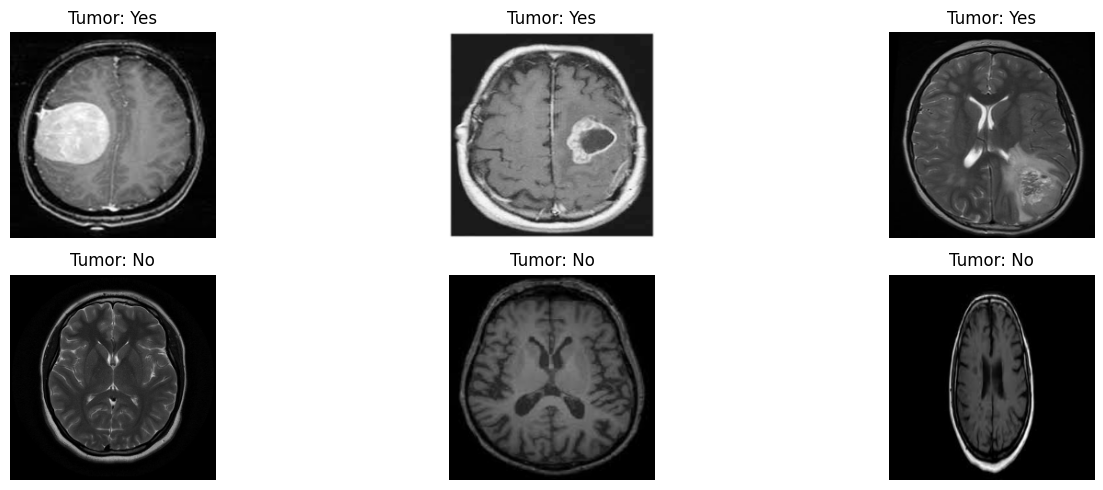

In [9]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[labels == 1][i])  # Filter images with label 'yes'
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(images[labels == 0][i])  # Filter images with label 'no'
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

<h3>Distribution des étiquettes</h3>

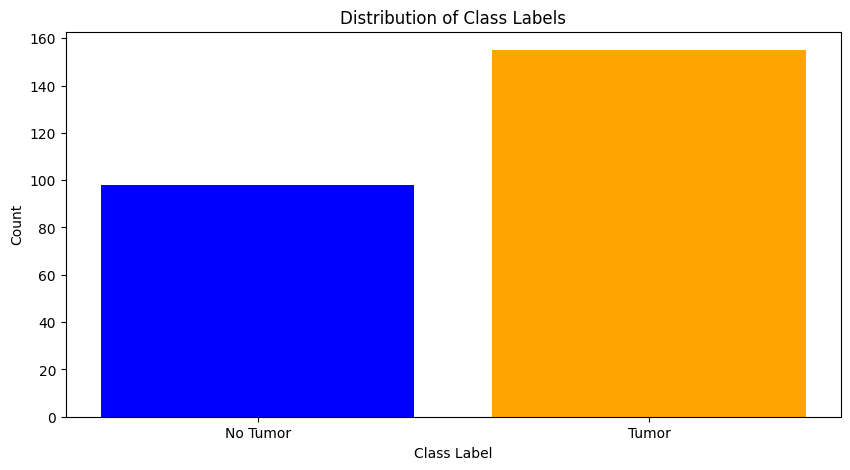

In [10]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

<h3>Fonction de recadrage du cerveau.</h3>

<p>Nous devons créer une fonction de recadrage pour nous concentrer sur notre région d'intérêt et supprimer les parties non désirées de l'image.</p>

In [11]:
def crop_brain_region(image, size):
    
    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)
    
    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)
    
    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)
    
    return contour_image, bounding_box_image, cropped_image, resized_image

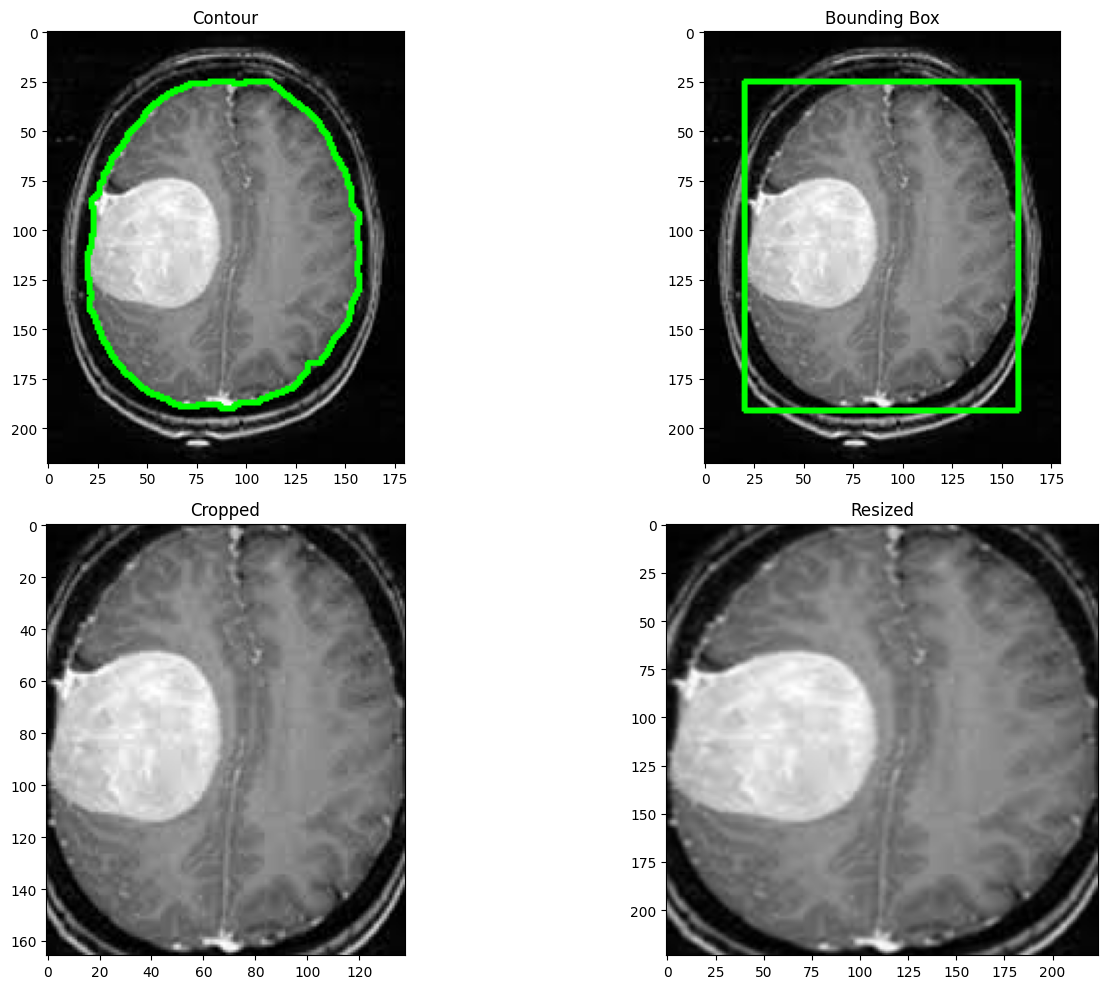

In [12]:
output_size = (224, 224)

example_image = cv2.imread('dataset/yes/Y1.jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in images:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

<p>Comparaison des images avant et après recadrage.</p>

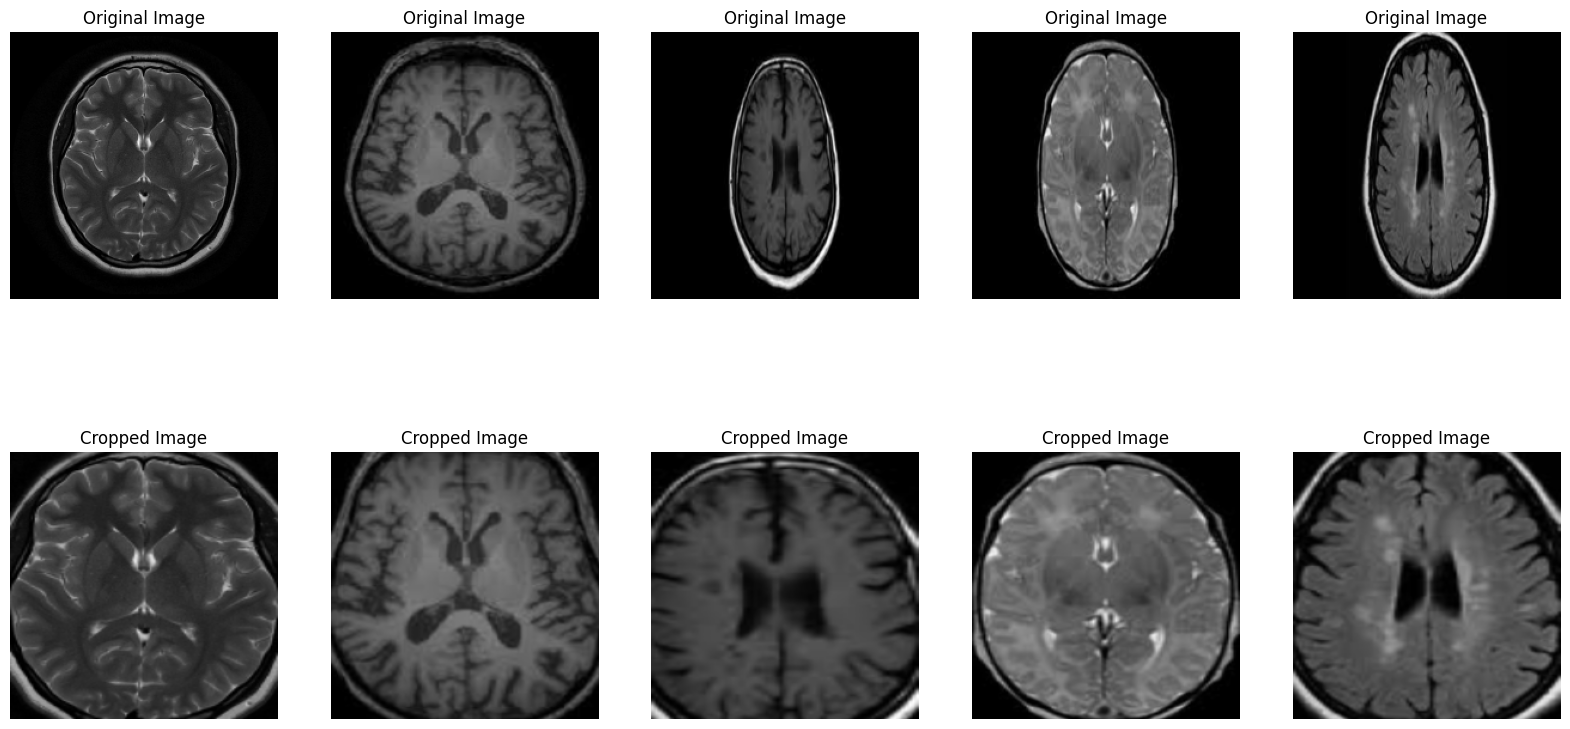

In [13]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(images[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

<h2 style="color:blue">Data Splitting</h2>

<p>Maintenant, nous divisons les données en ensembles d'entraînement, de validation et de test. Mais d'abord, nous devons transformer notre liste all_cropped en un tableau numpy.</p>

In [14]:
all_cropped=np.array(all_cropped)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(all_cropped, labels, test_size=0.2,shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [16]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (202, 224, 224, 3)
X_val shape: (25, 224, 224, 3)
X_test shape: (26, 224, 224, 3)
y_train shape: (202,)
y_val shape: (25,)
y_test shape: (26,)


In [17]:
train_folder = 'Train'
val_folder = 'Validation'
test_folder = 'Test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

label_map_decoded = {1: 'yes', 0: 'no'}

def copy_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = label_map_decoded[label]
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        img_filename = f'{class_name}_{i}.jpg'  # Assuming images are in JPG format
        img_path = os.path.join(class_folder, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Save image directly without converting to PIL format

In [18]:
copy_images_to_folder(X_train, y_train, train_folder)
copy_images_to_folder(X_val, y_val, val_folder)
copy_images_to_folder(X_test, y_test, test_folder)

<p>Normalisation des images pour qu'elles se situent dans la plage [0,1] au lieu de [0,255].</p>

In [19]:
print(np.max(X_train))
print(np.min(X_train))

255
0


In [20]:
X_train_scaled=X_train/255
X_test_scaled=X_test/255
X_val_scaled=X_val/255

In [21]:
print(np.max(X_train_scaled))
print(np.min(X_train_scaled))

1.0
0.0


<h2 style="color:blue">Baseline CNN</h2>

In [22]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

C:\Users\21263\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
epochs = 50 
batch_size = 32 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(X_train_scaled,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled,y_val),
                   callbacks=[early_stopping])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6041 - loss: 0.6865 - val_accuracy: 0.6400 - val_loss: 0.6302
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6257 - loss: 0.6403 - val_accuracy: 0.6400 - val_loss: 0.6106
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6257 - loss: 0.6158 - val_accuracy: 0.6400 - val_loss: 0.5927
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6427 - loss: 0.6100 - val_accuracy: 0.6400 - val_loss: 0.5765
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6496 - loss: 0.5895 - val_accuracy: 0.6800 - val_loss: 0.5542
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6905 - loss: 0.5636 - val_accuracy: 0.7200 - val_loss: 0.5403
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7318 - loss: 0.5508 - val_accuracy: 0.6800 - val_loss: 0.5308
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7627 - loss: 0.5237 - val_accuracy: 0.6800 - val_loss: 0.5142
Epoch 9/

<h4>la matrice de confusion de ce modèle sur les ensembles de validation et de test.</h4>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Accuracy on Validation Set: 0.720 %


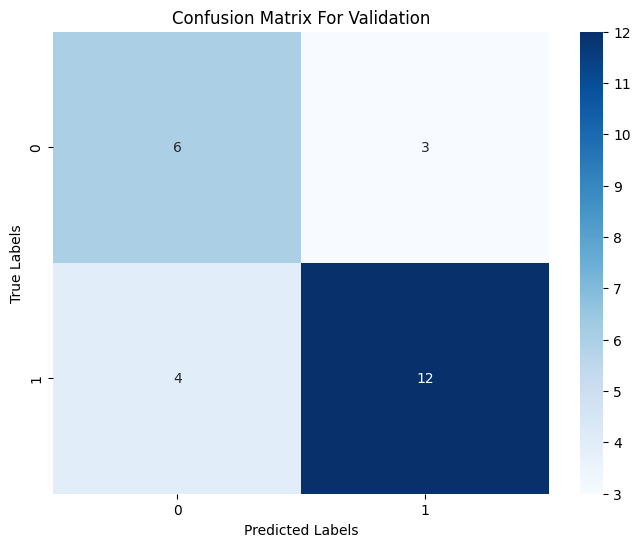

In [24]:
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Accuracy on Test Set: 0.769 %


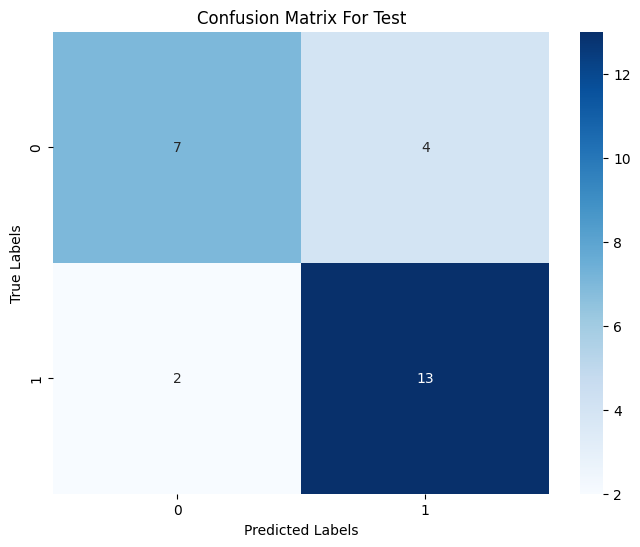

In [25]:
predictions = model.predict(X_test_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

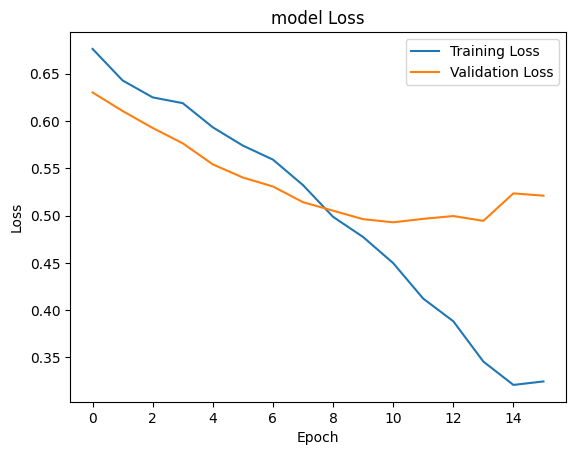

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

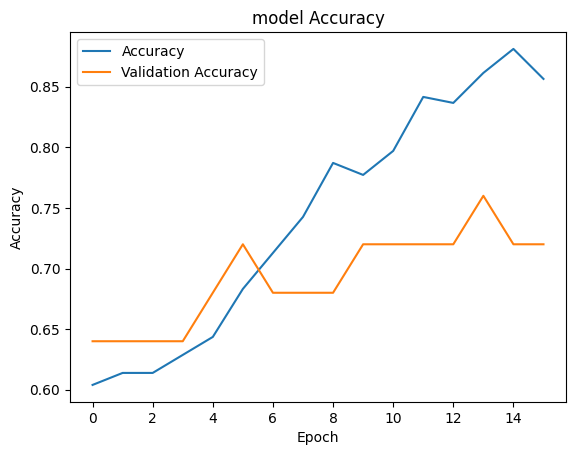

In [27]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h2 style="color:blue">Data Augmentation</h2>

<p>Utilisation de ImageDataGenerator pour effectuer l'augmentation de données sur l'ensemble d'entraînement. Cela aide à augmenter la diversité des données d'entraînement et à améliorer la capacité de généralisation du modèle.</p>

In [28]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_size=(224,224)

train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,  
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


<p>Visualisation des nouvelles images augmentées.</p>

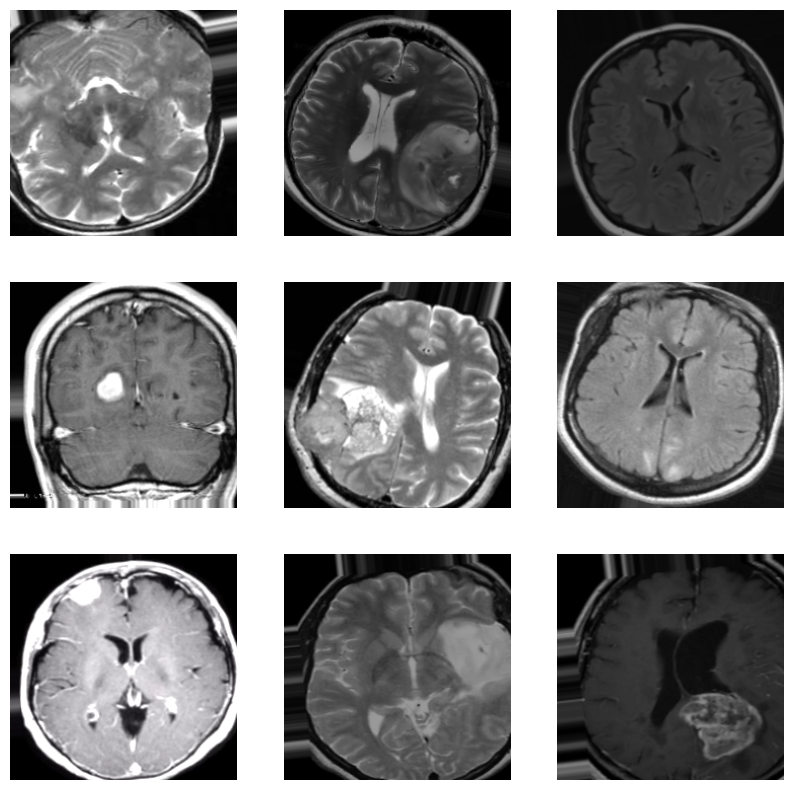

In [29]:
# Generate augmented images and labels
augmented_generator = datagen.flow(X_train, y_train, batch_size=32)

# Get one batch of augmented images and labels
augmented_images, augmented_labels = next(augmented_generator)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


<h2 style="color:blue">VGG 16</h2>

<p>Utilisation d'un modèle VGG16 pré-entraîné avec des poids keras-pretrained-models, car il fournit une architecture de réseau de neurones convolutionnels bien établie qui a été entraînée sur un grand ensemble de données (ImageNet). En utilisant un modèle pré-entraîné comme VGG16, nous pouvons bénéficier des caractéristiques apprises lors de son entraînement sur ImageNet, ce qui inclut la détection de différentes formes, textures et motifs dans les images.</p>

In [30]:
base_model = VGG16(weights='keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


C:\Users\21263\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 111s 15s/step - accuracy: 0.5127 - loss: 0.7362 - val_accuracy: 0.6400 - val_loss: 0.6114 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 102s 14s/step - accuracy: 0.6323 - loss: 0.6714 - val_accuracy: 0.6400 - val_loss: 0.5920 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 105s 15s/step - accuracy: 0.6117 - loss: 0.6631 - val_accuracy: 0.6400 - val_loss: 0.6432 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 104s 14s/step - accuracy: 0.5719 - loss: 0.6723 - val_accuracy: 0.7600 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 105s 14s/step - accuracy: 0.6772 - loss: 0.6309 - val_accuracy: 0.8400 - val_loss: 0.5578 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 105s 14s/step - accuracy: 0.6748 - loss: 0.6130 - val_accuracy: 0.6800 - val_loss: 0.4802 - learning_rate: 1.0000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 105s 14s/step - accuracy: 0.6761 - loss: 0.55

In [33]:
# Save the trained model
model.save('tumor_classifier_model.keras')  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Accuracy on Validation Set: 0.920000


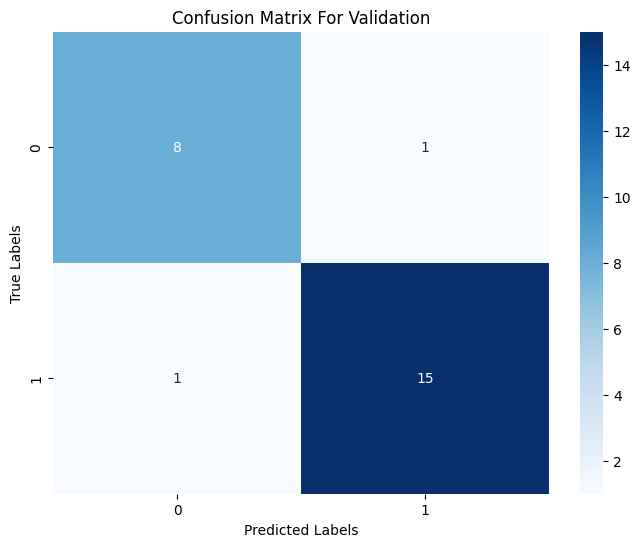

In [34]:
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Accuracy on Test Set: 0.923077


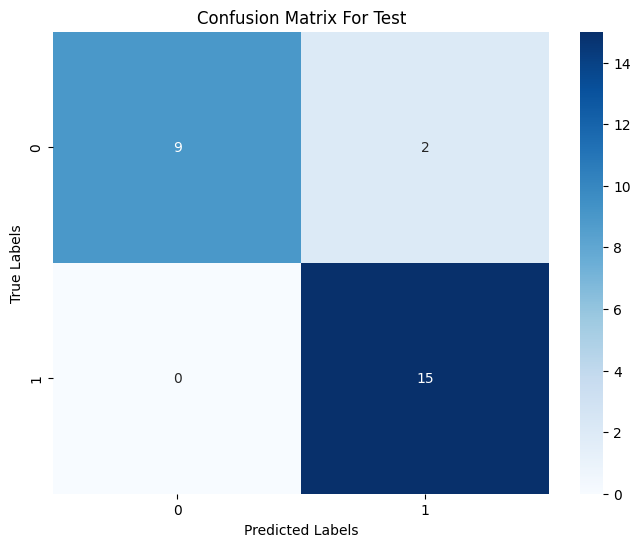

In [35]:
predictions = model.predict(X_test_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

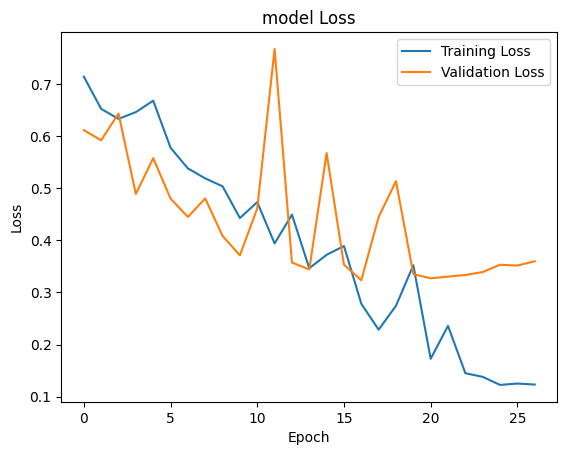

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

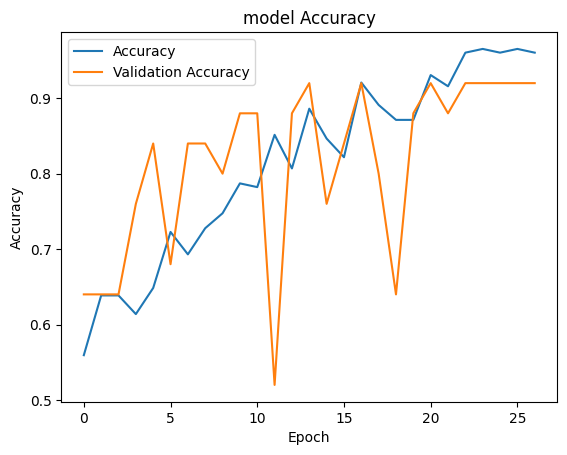

In [37]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h2>GUI for Brain Tumor Classifier</h2>

In [2]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy as np
import cv2
from keras.models import load_model

# Load the trained model
model = load_model('tumor_classifier_model.keras')

# Initialize GUI
top = tk.Tk()
top.geometry('800x600')
top.title('Tumor Classifier')
top.configure(background='#CDCDCD')

label = Label(top, background='#CDCDCD', font=('arial', 15, 'bold'))
image_label = Label(top)

def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def classify(file_path):
    global label_packed
    image = preprocess_image(file_path)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    result = "Tumor" if prediction > 0.5 else "No Tumor"
    label.configure(foreground='#011638', text="Prediction: " + result)

def show_classify_button(file_path):
    classify_b = Button(top, text="Classify Image", command=lambda: classify(file_path), padx=10, pady=5)
    classify_b.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
    classify_b.place(relx=0.79, rely=0.46)

def upload_image():
    try:
        file_path = filedialog.askopenfilename()
        uploaded = Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width() / 2.25), (top.winfo_height() / 2.25)))
        im = ImageTk.PhotoImage(uploaded)
        image_label.configure(image=im)
        image_label.image = im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload = Button(top, text="Upload an image", command=upload_image, padx=10, pady=5)
upload.configure(background='#364156', foreground='white', font=('arial', 10, 'bold'))
upload.pack(side=BOTTOM, pady=50)

image_label.pack(side=BOTTOM, expand=True)
label.pack(side=BOTTOM, expand=True)

heading = Label(top, text="Tumor Classifier", pady=20, font=('arial', 20, 'bold'))
heading.configure(background='#CDCDCD', foreground='#364156')
heading.pack()

top.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
